In [1]:
#Loading libraries
library(tidyverse)
library(tidymodels)
set.seed(7)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

# Introduction to the dataset

Diabetes .....

**Importing the data**

In [19]:
url <- "https://raw.githubusercontent.com/akshaj-24/DSCI_100_group07/main/data/Diabetes_data.csv"

diabetes_data <- read_csv(url)

diabetes_data <- diabetes_data |>  # Setting Outcome as a categorical data since we are predicting this
                mutate(Outcome = as_factor(Outcome)) |>
                mutate(Outcome = fct_recode(Outcome, "Diabetic" = "1", "Non-Diabetic" = "0")) |> #Renaming the categories
                mutate(Outcome = as_factor(Outcome)) |>
                filter(Glucose>0) |> #Filtering NA values
                filter(BloodPressure>0) |>
                filter(BMI>0)

head(diabetes_data)

Rows: 2768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35              0     33.6
2 1            85     66            29              0     26.6
3 8           183     64             0              0     23.3
4 1            89     66            23             94     28.1
5 0           137     40            35            168     43.1
6 5           116     74             0              0     25.6
  DiabetesPedigreeFunction Age Outcome     
1 0.627                    50  Diabetic    
2 0.351                    31  Non-Diabetic
3 0.672                    32  Diabetic    
4 0.167                    21  Non-Diabetic
5 2.288                    33  Diabetic    
6 0.201                    30  Non-Diabetic

**Variables:**

1. Pregnancies: Represents number of pregnancies for patients.
2. Glucose: Represents glucose levels for patients on a scale of mg/dL. A level of <99 mg/dL means normal levels, 100-125 mg/dL indicates pre-diabetes, and >126 mg/dL means diabetes.
3. BloodPressure: Average blood pressure for patients in mmHg. A level of below 80 is considered normal.
4. SkinThickness: Normal levels are 1 to 4 mm. Units here are mm^-1.
5. Insulin: Represents Insulin levels in mlU/L. Varies based on diabetic and glucose levels.
6. BMI: Represents obesity levels (based on Height and Weight). It is measured in kg/m^2. A normal BMI range is 18.5 to 24.9.
7. DiabetesPedigreeFunction: Represents the probability that a patient will have Diabetes on a scale of 0.08 to 2.42.
8. Age: Age of patients in years.
9. Outcome: Represents if patients tested positive for Diabetes. Categorical variable (Yes/No).

In [20]:
# Splitting the data into training and testing data

diabetes_split <- initial_split(diabetes_data, prop = 0.8, strata = Outcome) #Setting split to be 80% to roughly have 2200 training observations and 500 testing observations
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)

nrow(diabetes_training)
nrow(diabetes_testing)

[1] 2084

[1] 522

**Exploratory Analysis**

In [21]:
mean_vals <- diabetes_training |>
                group_by(Outcome) |>
            summarize(mean_pregnancies = mean(Pregnancies),
                      mean_glucose = mean(Glucose),
                      mean_bp = mean(BloodPressure),
                      mean_skin_thickness = mean(SkinThickness),
                      mean_insulin = mean(Insulin),
                      mean_BMI = mean(BMI),
                      mean_DPF = mean(DiabetesPedigreeFunction),
                      mean_age = mean(Age))

mean_vals

Outcome      mean_pregnancies mean_glucose mean_bp  mean_skin_thickness
1 Non-Diabetic 3.343054         111.2556     70.68150 20.41443           
2 Diabetic     4.801536         140.9770     74.61076 23.67350           
  mean_insulin mean_BMI mean_DPF  mean_age
1  72.59171    30.81297 0.4339701 31.19186
2 107.83739    35.27657 0.5697029 36.08835

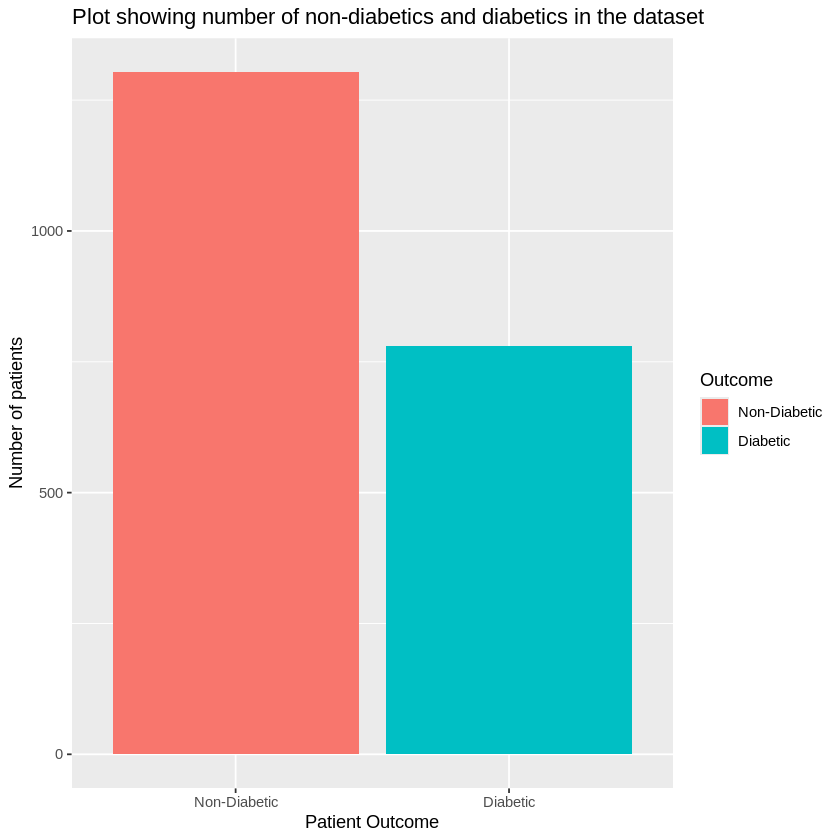

In [22]:
# PLOT 5: Show split of Diabetic outcomes in the data

diabetes_split <- ggplot(diabetes_training, aes(x=Outcome, fill = Outcome)) + 
                geom_bar() + 
                labs(x = "Patient Outcome",
                     y = "Number of patients") + 
                ggtitle("Plot showing number of non-diabetics and diabetics in the dataset")

diabetes_split

It can be observed that the number of diabetic people is around 850 out of 2200, making the dataset contain about 38.6% diabetics.

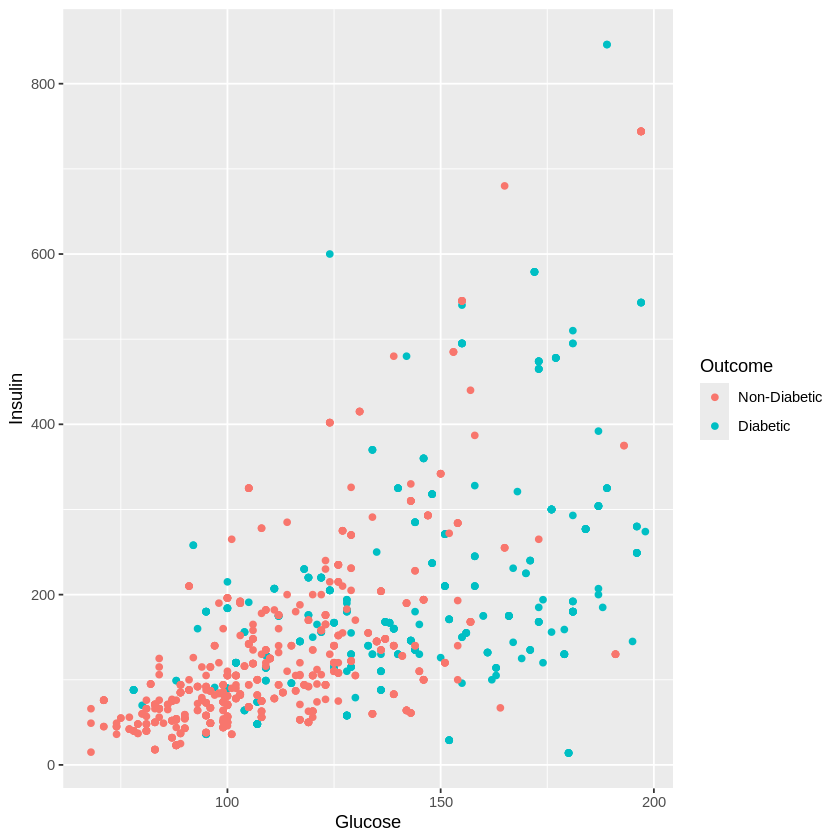

In [23]:
# PLOT 2: Glucose vs Insulin

glucose_insulin <- diabetes_training |>
            filter(Glucose > 0) |>
            filter(Insulin > 0) |>
            ggplot(aes(x = Glucose, y = Insulin, color = Outcome)) + 
            geom_point()

glucose_insulin

There is a strong positive relationship between the previous two variables, Insulin and Glucose. It can also be observed that the Diabetic patients have a higher Insluin and Glucose value than Non-diabetic patients.

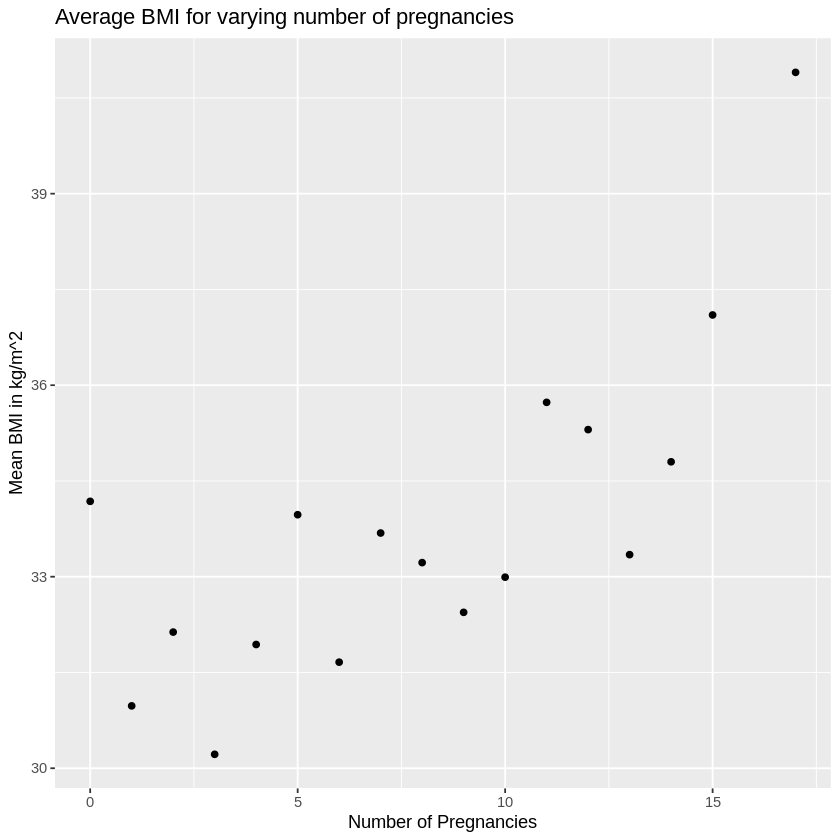

In [24]:
# PLOT 4: Pregnancies vs BMI

preg_BMI_data <- diabetes_training |>
#            filter(Pregnancies > 0) |>
            filter(BMI > 0) |>
            group_by(Pregnancies) |>
            summarize(BMI_mean = mean(BMI))

preg_BMI <- preg_BMI_data |>
            ggplot(aes(x = Pregnancies, y = BMI_mean)) + 
            geom_point() + 
            labs(x = "Number of Pregnancies",
                 y = "Mean BMI in kg/m^2") + 
            ggtitle("Average BMI for varying number of pregnancies")

preg_BMI

It can be seen that the average BMI increases for increasing number of pregnancies.

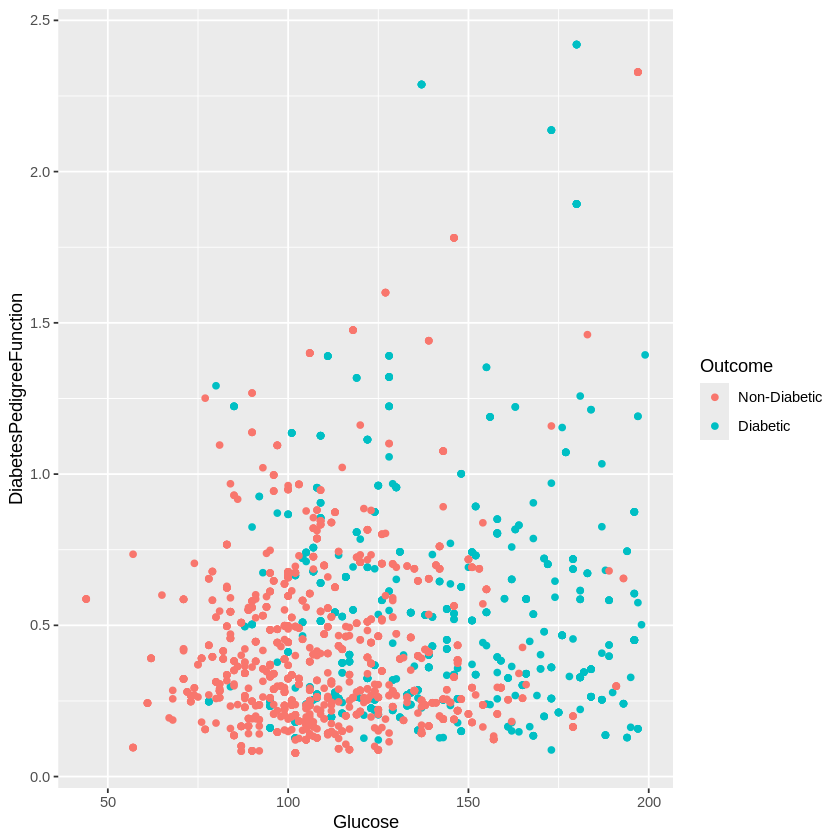

In [25]:
# age vs diabetes pedigree func

glucose_prob <- diabetes_training |>
            filter(Glucose > 0) |>
            ggplot(aes(x=Glucose, y= DiabetesPedigreeFunction, color=Outcome)) + 
            geom_point()


glucose_prob

There is a weak positive relationship between the DPF (Diabetes Pedigree Function) and Glucose. This indicates that for increasing glucose levels, there is an increased probability for Diabetes which is supported by the fact that Diabetic individuals have a higher Glucose level.

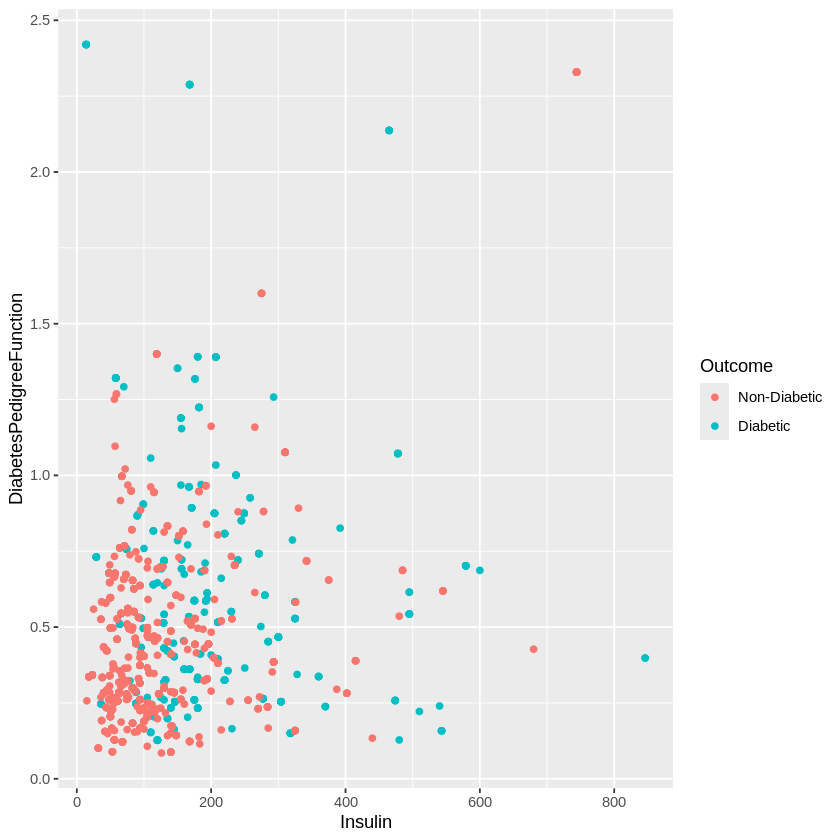

In [26]:
glucose_prob <- diabetes_training |>
            filter(Insulin > 0) |>
            ggplot(aes(x=Insulin, y= DiabetesPedigreeFunction, color = Outcome)) + 
            geom_point()


glucose_prob

There is a moderately positive relationship between the DPF (Diabetes Pedigree Function) and Insulin. This indicates that for increasing insulin levels, there is an increased probability for Diabetes. Diabetic individuals also have a higher mean insulin.

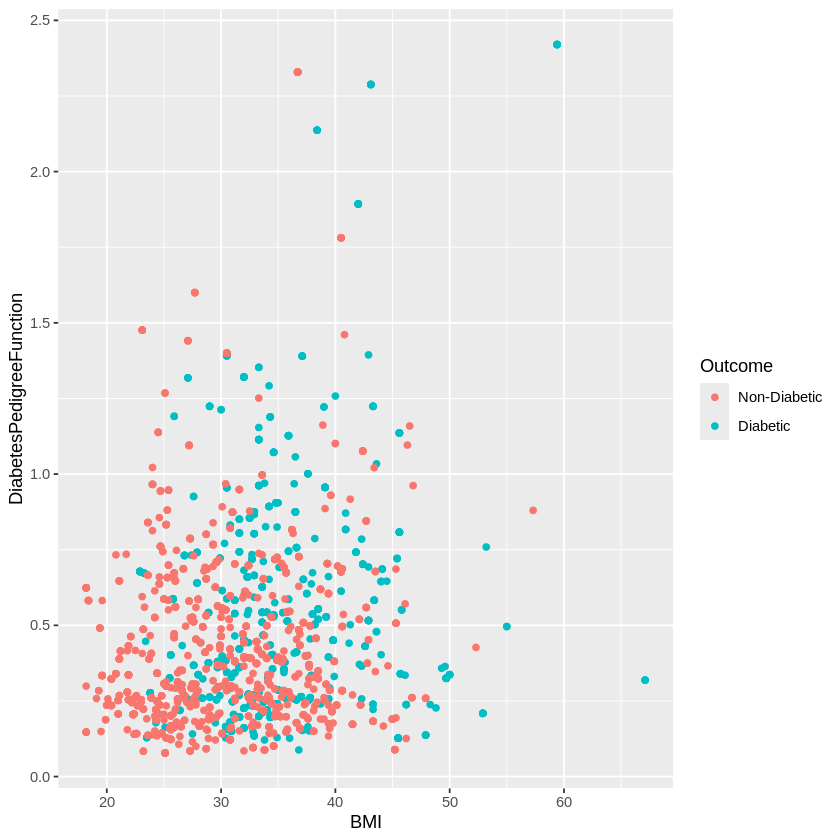

In [27]:
# age vs diabetes pedigree func

glucose_prob <- diabetes_training |>
            filter(BMI > 0) |>
            ggplot(aes(x=BMI, y= DiabetesPedigreeFunction, color= Outcome)) + 
            geom_point()


glucose_prob

There is a moderately positive relationship between the DPF (Diabetes Pedigree Function) and BMI. This indicates that for increasing BMI values, there is an increased probability for Diabetes. It can also be seen that Diabetic individuals generally have a higher BMI.

# Choosing our predictors:

# Classification

**Finding our best K values:**

Our goal is to find the best value for the $k$-nearest neighbours, providing the highest accuracy in predictions. In the code below, we create a classifier and perform cross-validation to split the training data, train the model with one set and use the other to evaluate it because we can not use testing data. Our next steps are:

1. Use the recipe function to center and scale the data.
2. Perform cross-validation with ten folds, using vfold_cv, on the training data. We use ten folds because if we only split the data once, the results strongly depend on the observations that end up being in the validation set, so using more folds increases the accuracy.
3. Create a k-nearest model with neighbours = tune() instead of a value to find the best value of k-nearest neighbours.
4. Add the recipe and model to a workflow, using tune_grid to fit. This worfklow runs cross validation on a range of k-nearest neighbours values that is specified in gridvals.
5. Find the best k value by filtering for accuracy and plotting a line plot with the accuracy estimate on the y-axis and k on the x-axis.
6. Seeing that there is no overfitting and underfitting in the classifier.

In [28]:
#Creating recipe and performing standardization
diabetes_recipe <- recipe(Outcome ~ Glucose + BMI + Pregnancies + Insulin + DiabetesPedigreeFunction, data = diabetes_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

#K-nearest neighbor spec
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#10-fold cross validation
diabetes_vfold <- vfold_cv(diabetes_training, v = 10, strata = Outcome)

gridvals <- tibble(neighbors = seq(1:20))

# Create workflow
knn_results <- workflow() |>
      add_recipe(diabetes_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = diabetes_vfold, grid = gridvals) |>
      collect_metrics() |>  # Collect metrics, filter for accuracy
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))


head(knn_results)


neighbors mean     
1 1         0.9601513
2 2         0.9601513
3 3         0.9496110
4 4         0.9496110
5 5         0.9160695
6 6         0.9160695

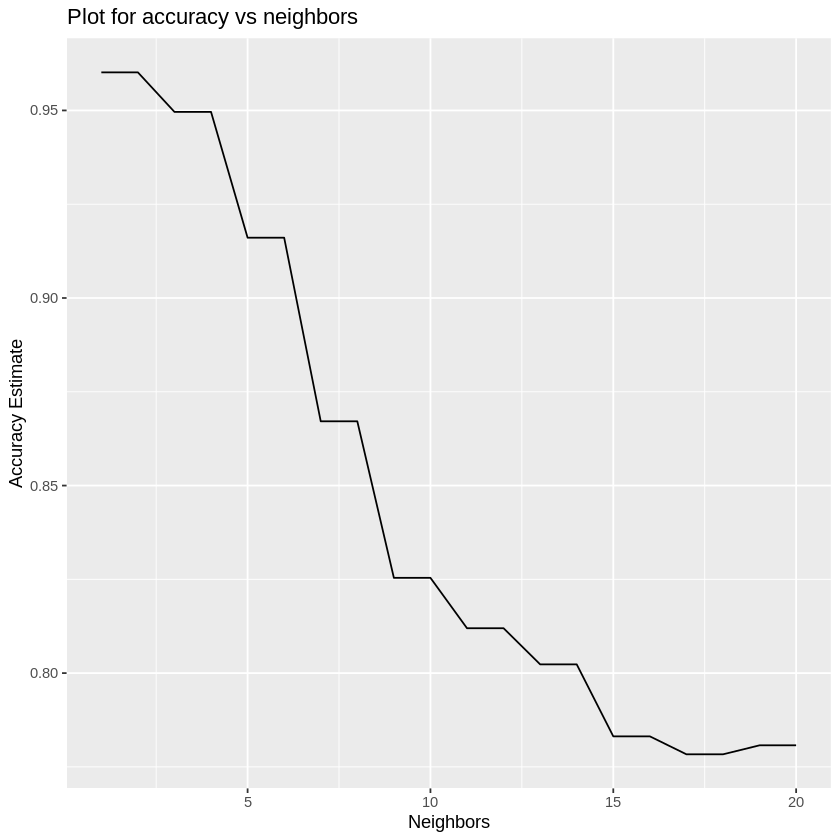

In [29]:
#Plotting a plot for accuracy vs neighbors


accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      #geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Plot for accuracy vs neighbors") 

accuracy_versus_k

Explain why you chose this k

**Compare this to a majority classifier**

In [30]:
num_rows = nrow(diabetes_training)

proportions <- diabetes_training |>
                group_by(Outcome) |>
                summarize(count = n()) |>
                mutate(percentage = 100* (count / num_rows))

proportions

Outcome      count percentage
1 Non-Diabetic 1303  62.52399  
2 Diabetic      781  37.47601

Hence our k value is better than a majority classifier : EXPLAIN

**Building the final model**

In [31]:
set.seed(7)

knn_spec_final <- nearest_neighbor(weight_func="rectangular", neighbors = 1) |>
    set_engine("kknn") |>
    set_mode("classification")

fit <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(knn_spec_final) |>
    fit(data = diabetes_training)

fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.03934741
Best kernel: rectangular
Best k: 1

**Checking prediction metrics**

In [32]:
diabetes_training_predictions <- predict(fit, diabetes_training) |>
                                    bind_cols(diabetes_training)

diabetes_conf_mat <- diabetes_training_predictions |> 
                    conf_mat(truth=Outcome, estimate=.pred_class) 

head(diabetes_training_predictions)

diabetes_conf_mat

diabetes_accuracy <- diabetes_training_predictions|> 
                metrics(truth = Outcome, estimate = .pred_class) |>
                filter(.metric == "accuracy")

diabetes_accuracy

.pred_class Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 Diabetic     6          148     72            35              0     33.6
2 Diabetic     8          183     64             0              0     23.3
3 Diabetic     0          137     40            35            168     43.1
4 Diabetic     3           78     50            32             88     31.0
5 Diabetic     2          197     70            45            543     30.5
6 Diabetic    10          168     74             0              0     38.0
  DiabetesPedigreeFunction Age Outcome 
1 0.627                    50  Diabetic
2 0.672                    32  Diabetic
3 2.288                    33  Diabetic
4 0.248                    26  Diabetic
5 0.158                    53  Diabetic
6 0.537                    34  Diabetic

              Truth
Prediction     Non-Diabetic Diabetic
  Non-Diabetic         1303        0
  Diabetic                0      781

.metric  .estimator .estimate
1 accuracy binary     1

**Finally testing the model**

In [33]:
set.seed(7)

diabetes_testing_predictions <- predict(fit, diabetes_testing) |>
                                bind_cols(diabetes_testing)

testing_conf_mat <- diabetes_testing_predictions |>
                    conf_mat(truth=Outcome, estimate=.pred_class)

testing_accuracy <- diabetes_testing_predictions |> 
                metrics(truth = Outcome, estimate = .pred_class) |>
                filter(.metric == "accuracy")

testing_accuracy

.metric  .estimator .estimate
1 accuracy binary     0.967433

EXPLAIN CLASSIFIER